##**PASO 1:** DEFINICION DE LIBRERIAS A UTILIZAR

In [221]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
import nltk
import matplotlib.pyplot as plt

In [222]:
#variables de evaluacion de modelo
evaluacion_metricas  = pd.DataFrame()
tam_batch_size = 0
tam_epochs = 0
tam_validation_split = 0.0

##**PASO 2:** IMPORTACION DE DATASET RECOMENDACIONES

In [223]:
#Importacion de Dataset sintomas
df_Síntomas  = pd.read_excel("CORPUS_SINTOMAS_GYE_COVID19_DE_2020_A_2021.xlsx")
df_Síntomas.head(3)

,No.,Fecha Encuesta,1. ¿Ciudad que reside?,2. Ha tenido coronavirus?,3. Seleccione la Edad,4. ¿Género?,5. ¿Qué variante del Virus lo contagio?,6. ¿Fecha de contagio?,7. ¿Intensidad de los sí­ntomas?,8. ¿Lugar de contagio?,...,Presión en el pecho,Problema circulatorio,Prurito,Resfriado,Sarpullido,Saturación baja al respirar,Sudoración excesiva,Taquicardia,Tos,Vómito
0,1,2021-09-12 10:41:46,Guayaquil,Si,Entre 26 a 64 años,M,Alfa,2021-03-16 00:00:00,Fuerte,Trabajo,...,0,0,0,0,0,0,0,0,0,0
1,2,2021-09-12 14:21:34,Guayaquil,Si,Entre 26 a 64 años,F,Alfa,2020-03-12 00:00:00,Fuerte,OTRO,...,0,0,0,0,0,0,0,0,0,0
2,3,2021-09-12 16:21:57,Guayaquil,Si,Entre 18 a 25 años,F,No Sabe,2020-03-19 00:00:00,Leve,Medio de Trasporte,...,0,0,0,0,0,0,0,0,1,0


##**PASO 3:** EXPLORACION DE DATOS QUE CONTIENE LA DATASET

In [224]:
#verificacion de columnas existentes y los tipos de datos que contiene
df_Síntomas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2873 entries, 0 to 2872
Data columns (total 72 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   No.                                                      2873 non-null   int64 
 1   Fecha Encuesta                                           2873 non-null   object
 2   1. ¿Ciudad que reside?                                   2873 non-null   object
 3   2. Ha tenido coronavirus?                                2873 non-null   object
 4   3. Seleccione la Edad                                    2873 non-null   object
 5   4. ¿Género?                                              2873 non-null   object
 6   5. ¿Qué variante del Virus lo contagio?                  2873 non-null   object
 7   6. ¿Fecha de contagio?                                   2873 non-null   object
 8   7. ¿Intensidad de los sí­ntomas?      

In [225]:
#verificacion de columnas y filas de la data
df_Síntomas.shape[:]

(2873, 72)

###Variables Numericas

In [226]:
#para presentar los datos numericos se usa el metodo ._get_numeric_data()
df_Síntomas_datos_numericos= df_Síntomas._get_numeric_data()

In [227]:
#muestra el numero de columnas numericas
# nota:
# No se considera fechas y valores numericos y textos en rango ej: edad entre 26 a 40
len(df_Síntomas_datos_numericos.axes[1])

61

###Variables Categoricas

In [228]:
df_Síntomas_datos_categoricos = df_Síntomas.select_dtypes(exclude=['float64','float32','int32','int64'])

In [229]:
# muestra el numero de de categoricas
len(df_Síntomas_datos_categoricos.axes[1])

11

##**PASO 4:** PREPROCESAMIENTO DE DATOS

###4.1.1 EVALUACION DE CALIDAD DE DATOS



####Proceso de Valores Perdidos

In [230]:
#verificacion de variables con valores NaN
val_NaN = df_Síntomas.isnull().any().sum()
val_NaN

0

In [231]:
#número total de NaN en la Dataset.
df_Síntomas.isnull().sum()

No.                            0
Fecha Encuesta                 0
1. ¿Ciudad que reside?         0
2. Ha tenido coronavirus?      0
3. Seleccione la Edad          0
                              ..
Saturación baja al respirar    0
Sudoración excesiva            0
Taquicardia                    0
Tos                            0
Vómito                         0
Length: 72, dtype: int64

####Grafico para visualizar los valores NaN o perdidos

###4.1.2 Normalización del texto de entrada

Poner el texto en minúsculas, eliminar el texto entre corchetes, eliminar la puntuación y eliminar las palabras que contienen números

In [232]:
#definicion de una funcion para cambiar datos que contengan tilde por una sin tilde,
#convertir de mayuscula a minuscula
#eliminacion de caracteres especiales
def Clean_txt(text):
    text = str(text)
    text = text.lower()
    text = re.sub('á', 'a', text)
    text = re.sub('é', 'e', text)
    text = re.sub('í', 'i', text)
    text = re.sub('ó', 'o', text)
    text = re.sub('ú', 'u', text)
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    return text

In [233]:
#se aplica la funcion "limpieza_tilde" a la columna "10. Describa lo más detallado ¿Qué síntomas ha tenido?-SIN DEPURAR"
df_Síntomas["Síntomas-Normalizado"] = df_Síntomas.apply(lambda x: Clean_txt( x["11. ¿Qué síntomas tuvo?"]), axis=1)

###4.1.3  Balaceo de los datos de Salida

In [234]:
df_Síntomas.iloc[ : , 13:71 ].sum()

Afectación psicológica           20
Alergia                          12
Alucinación                       2
Amigdalitis                      14
Arritmia                          1
Asintomatismo                   204
Colitis                           1
Congestión nasal                 52
Conjuntivitis                    12
Convulsión                        1
Desmayo                           6
Diarrea                          94
Dificultad al hablar              3
Dificultad para moverse           6
Dificultad para Respirar        359
Disgeusia                         6
Dolor articular                  69
Dolor de cabeza                 940
Dolor de encías                   2
Dolor de espalda                 67
Dolor de estómago                38
Dolor de garganta               201
Dolor de huesos                  89
Dolor en extremidades             9
Dolor muscular                  245
Dolor ocular                     18
Dolor renal                       2
Dolor torácico              

In [235]:
sintomas_totalizado = df_Síntomas.iloc[ : , 13:71 ].sum()

#### Visualización del desbalanceo de datos

In [236]:
datos_totales_sint = df_Síntomas.iloc[ : , 13:71 ].sum()

#### Elección del 80% de datos de entrada hallando el 20% de Sintomas más mencionados

In [237]:
lista_col = ['Dolor de cabeza', 'Pérdida de Olfato', 'Pérdida de Gusto', 'Malestar general', 'Fiebre', 'Tos',  'Dificultad para Respirar', 'Fátiga', 'Dolor muscular', 'Asintomatismo', 'Dolor de garganta', 'Gripe']

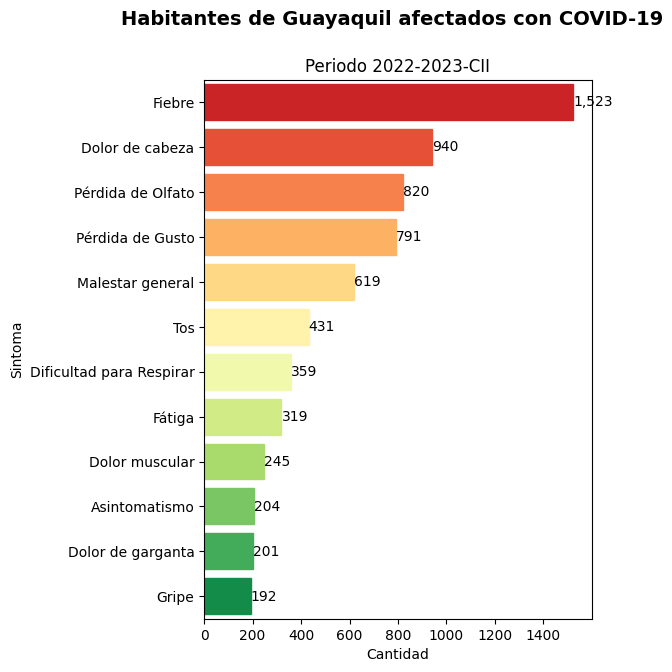

<Figure size 640x480 with 0 Axes>

In [238]:
import seaborn as sns
import pandas as pd

count_ages = datos_totales_sint[lista_col]
namesbars = df_Síntomas[lista_col].columns

# Ordenar los datos de manera descendente
sorted_data = count_ages.sort_values(ascending=False)

# Crear un dataframe con los datos ordenados
df_sorted = pd.DataFrame({'Sintoma': sorted_data.index, 'Cantidad': sorted_data.values})

# Definir la paleta de colores
color_palette = sns.color_palette("RdYlGn", len(df_sorted))

# Crear el gráfico de barras horizontales
plt.figure(figsize=(5, 7))
sns.barplot(x='Cantidad', y='Sintoma', data=df_sorted, palette=color_palette)

# Asignar colores a las barras según los valores
for i, bar in enumerate(plt.gca().patches):
    color = color_palette[i] if i < len(color_palette) else color_palette[-1]
    bar.set_color(color)

    # Agregar el valor numérico a la derecha de la barra
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{int(bar.get_width()):,}', ha='left', va='center')

plt.title('Periodo 2022-2023-CII')
plt.suptitle('Habitantes de Guayaquil afectados con COVID-19', fontsize=14, fontweight='bold')

plt.xlabel('Cantidad')
plt.ylabel('Sintoma')

plt.show()
plt.savefig('Sintomas relevantes de habitantes afectados con covid19 2021-2022')


#**Analisis de Frecuencia**

In [239]:
df_Síntomas.iloc[ : , 0:13].head(3)

,No.,Fecha Encuesta,1. ¿Ciudad que reside?,2. Ha tenido coronavirus?,3. Seleccione la Edad,4. ¿Género?,5. ¿Qué variante del Virus lo contagio?,6. ¿Fecha de contagio?,7. ¿Intensidad de los sí­ntomas?,8. ¿Lugar de contagio?,9. ¿Cuantas dosis tenia aplicadas previo a contagiarse?,"10. ¿Qué vacuna recibió, previo a contagiarse?",11. ¿Qué síntomas tuvo?
0,1,2021-09-12 10:41:46,Guayaquil,Si,Entre 26 a 64 años,M,Alfa,2021-03-16 00:00:00,Fuerte,Trabajo,0,Astrazeneca,"FALTA DE AIRE, PERDIDA DEL GUSTO, CANSANCIO EX..."
1,2,2021-09-12 14:21:34,Guayaquil,Si,Entre 26 a 64 años,F,Alfa,2020-03-12 00:00:00,Fuerte,OTRO,0,Sinovac,"Falta de aire, fiebre alta, mucho dolor de cuerpo"
2,3,2021-09-12 16:21:57,Guayaquil,Si,Entre 18 a 25 años,F,No Sabe,2020-03-19 00:00:00,Leve,Medio de Trasporte,0,Sinovac,Perdida del gusto y el olfato y tos por las no...


In [240]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Columnas de entrada y columnas codificadas
columnas_entrada = ['1. ¿Ciudad que reside?', '2. Ha tenido coronavirus?', '3. Seleccione la Edad', '4. ¿Género?',
                    '5. ¿Qué variante del Virus lo contagio?',  '7. ¿Intensidad de los sí­ntomas?',
                    '8. ¿Lugar de contagio?']

columnas_codificadas = ['ciudad_reside_le', 'tuvo_coronavirus_le', 'Edad_le', 'Género_le', 'variante_Virus_tuvo_le',
                         'intensidad_sí­ntomas_le', 'Lugar_contagio']

# Crear nuevas columnas codificadas y asignarles los valores correspondientes
for col_entrada, col_codificada in zip(columnas_entrada, columnas_codificadas):
    le = LabelEncoder()
    df_Síntomas[col_codificada] = le.fit_transform(df_Síntomas[col_entrada])

In [241]:
df_Síntomas = df_Síntomas.rename(columns={'1. ¿Ciudad que reside?': 'Ciudad_reside'})
df_Síntomas = df_Síntomas.rename(columns={'2. Ha tenido coronavirus?': 'tuvo_COVID.19'})
df_Síntomas = df_Síntomas.rename(columns={'3. Seleccione la Edad': 'Rango_edad'})
df_Síntomas = df_Síntomas.rename(columns={'4. ¿Género?': 'Género'})
df_Síntomas = df_Síntomas.rename(columns={'5. ¿Qué variante del Virus lo contagio?': 'Variante_COVID.19'})
df_Síntomas = df_Síntomas.rename(columns={'7. ¿Intensidad de los sí­ntomas?': 'Intensidad_sí­ntomas'})
df_Síntomas = df_Síntomas.rename(columns={'8. ¿Lugar de contagio?': 'Lugar_contagio'})

In [242]:
# Renombrar la columna '9. ¿Cuantas dosis tenia aplicadas previo a contagiarse?' a 'Vacuna_recibió_antes_contagiarse'
df_Síntomas = df_Síntomas.rename(columns={'9. ¿Cuantas dosis tenia aplicadas previo a contagiarse?': 'Vacuna_recibió_antes_contagiarse'})
df_Síntomas = df_Síntomas.rename(columns={'6. ¿Fecha de contagio?': 'Fecha_contagio'})
df_Síntomas = df_Síntomas.rename(columns={'10. ¿Qué vacuna recibió, previo a contagiarse?': 'vacuna_recibió_ac'})

In [243]:
df_Síntomas = df_Síntomas.rename(columns={'11. ¿Qué síntomas tuvo?': 'síntomas'})

In [244]:
# Extraer el año de la columna '6. ¿Fecha de contagio?' y asignarlo a 'año_contagio'
df_Síntomas['Fecha_contagio'] = pd.to_datetime(df_Síntomas['Fecha_contagio'], errors='coerce')

# Truncar los nanosegundos a cero
df_Síntomas['Fecha_contagio'] = df_Síntomas['Fecha_contagio'].dt.round('s')

df_Síntomas['año_contagio'] = df_Síntomas['Fecha_contagio'].dt.year
df_Síntomas['mes_contagio'] = df_Síntomas['Fecha_contagio'].dt.month
df_Síntomas['dia_contagio'] = df_Síntomas['Fecha_contagio'].dt.day


In [245]:
#df_Síntomas['año_mes'] = df_Síntomas['año_contagio'].astype(str) + df_Síntomas['mes_contagio'].astype(str).str.zfill(2)

df_Síntomas['año_mes'] = (df_Síntomas['año_contagio']*100 + df_Síntomas['mes_contagio'])

In [246]:
df_Síntomas['año_mes'] = df_Síntomas['año_mes'].astype(int).astype(str)

In [247]:
df_Síntomas2 = df_Síntomas.iloc[:, np.r_[3:6, 8:11, 7, 11, 72:82]]

In [248]:
# Seleccionar las columnas 'variante_Virus_tuvo_le' y 'Género_le' del DataFrame
df_Síntomas_sc = df_Síntomas.iloc[   :  ,np.r_[4:8, 83]]

In [249]:
df_Síntomas_sc.head(3)

,Rango_edad,Género,Variante_COVID.19,Fecha_contagio,año_mes
0,Entre 26 a 64 años,M,Alfa,2021-03-16,202103
1,Entre 26 a 64 años,F,Alfa,2020-03-12,202003
2,Entre 18 a 25 años,F,No Sabe,2020-03-19,202003


<ipython-input-254-6aa6ed15fafe>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Síntomas_sc['año_mes'] = pd.to_datetime(df_Síntomas_sc['año_mes'], format='%Y%m')


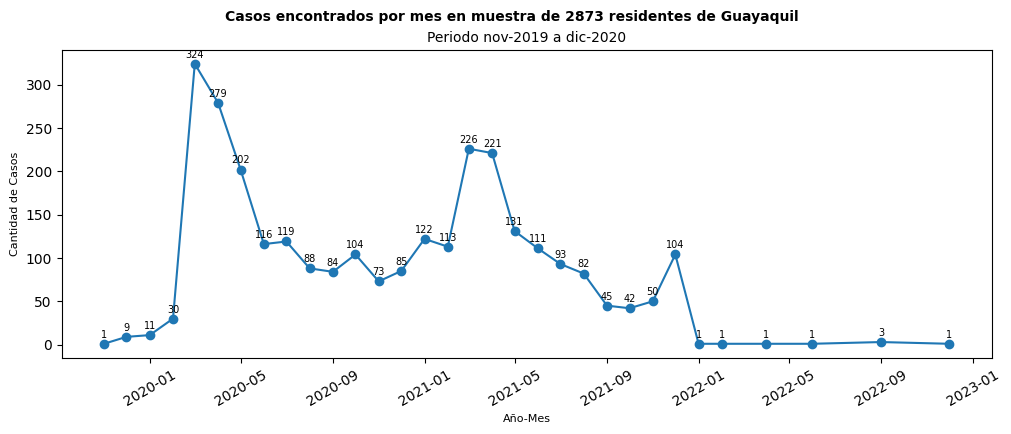

In [254]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir el campo año_mes a tipo datetime
df_Síntomas_sc['año_mes'] = pd.to_datetime(df_Síntomas_sc['año_mes'], format='%Y%m')

# Agrupar por año_mes y género y contar los casos
conteo_casos = df_Síntomas_sc.groupby(['año_mes', 'Género']).size().unstack(fill_value=0)

# Obtener los totales por año_mes
totales = conteo_casos.sum(axis=1)

# Ordenar los resultados por año_mes en forma ascendente
totales = totales.sort_index()

# Crear el gráfico lineal
plt.figure(figsize=(12, 4))
plt.plot(totales.index, totales.values, marker='o')

# Mostrar los valores numéricos arriba de la línea con un desplazamiento
for x, y in zip(totales.index, totales):
    plt.text(x, y+5, str(y), ha='center', va='bottom', fontsize=7)

# Configurar los ejes y el título del gráfico
plt.xlabel('Año-Mes', fontsize=8)
plt.ylabel('Cantidad de Casos', fontsize=8)
plt.suptitle('Casos encontrados por mes en muestra de 2873 residentes de Guayaquil', fontsize=10, fontweight='bold')
plt.title('Periodo nov-2019 a dic-2020', fontsize=10)

# Rotar las etiquetas del eje x para una mejor legibilidad
plt.xticks(rotation=30)

# Mostrar el gráfico
plt.show()


<ipython-input-255-f9f8df8239d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Síntomas_sc['año_mes'] = pd.to_datetime(df_Síntomas_sc['año_mes'], format='%Y%m')


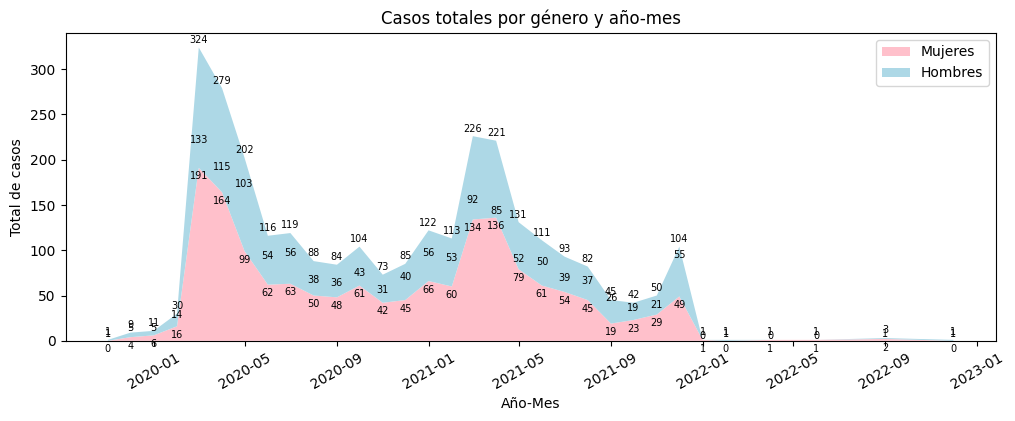

In [255]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir el campo año_mes a tipo datetime
df_Síntomas_sc['año_mes'] = pd.to_datetime(df_Síntomas_sc['año_mes'], format='%Y%m')

# Agrupar por año_mes y género y contar los casos
conteo_casos = df_Síntomas_sc.groupby(['año_mes', 'Género']).size().unstack(fill_value=0)

# Obtener los totales por año_mes
totales = conteo_casos.sum(axis=1)

# Obtener los totales de mujeres por año_mes
totales_mujeres = conteo_casos['F']

# Obtener los totales de hombres por año_mes
totales_hombres = conteo_casos['M']

# Ordenar los resultados por año_mes en forma ascendente
totales = totales.sort_index()
totales_mujeres = totales_mujeres.sort_index()
totales_hombres = totales_hombres.sort_index()

# Crear el gráfico de áreas apiladas
plt.figure(figsize=(12, 4))
plt.stackplot(totales.index, totales_mujeres, totales_hombres, labels=['Mujeres', 'Hombres'], colors=['pink', 'lightblue'])

# Mostrar los valores de casos totales
for x, y in zip(totales.index, totales):
    plt.text(x, y+3 , str(y), ha='center', va='bottom', fontsize=7)

# Mostrar los valores de casos de mujeres
for x, y in zip(totales.index, totales_mujeres):
    plt.text(x, y-15, str(y), ha='center', va='bottom', fontsize=7)

# Mostrar los valores de casos de hombres
for x, y in zip(totales.index, totales_hombres):
    plt.text(x, y+y*5/8, str(y), ha='center', va='bottom', fontsize=7)

# Configurar los ejes y la leyenda
plt.xlabel('Año-Mes')
plt.ylabel('Total de casos')
plt.title('Casos totales por género y año-mes')
plt.legend()

# Rotar las etiquetas del eje x para una mejor legibilidad
plt.xticks(rotation=30)

# Mostrar el gráfico
plt.show()


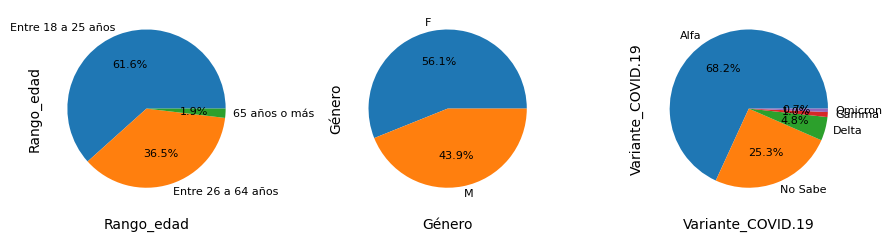

In [256]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que `train2` es tu dataframe original

# Configurar el tamaño de la figura
fig, axes = plt.subplots(1, 3, figsize=(9, 4))

# Iterar sobre las columnas y crear los gráficos
for i, (column, ax) in enumerate(zip(df_Síntomas_sc.columns, axes.flatten())):
    # Verificar si la columna es numérica o categórica
    if df_Síntomas_sc[column].dtype == 'object':
        # Crear un gráfico de pastel para columnas categóricas
        counts = df_Síntomas_sc[column].value_counts()
        ax.pie(counts, labels=counts.index, autopct='%1.1f%%', textprops={'fontsize': 8})
        ax.set_aspect("equal")  # Asegurar que el gráfico sea circular

        # Colocar el nombre de la variable debajo del gráfico de pastel
        ax.set_title(column, y=-0.15, fontsize=10)

    else:
        # Crear un histograma para columnas numéricas
        sns.histplot(data=df_Síntomas_sc, x=column, ax=ax)

    # Establecer el título de la columna como etiqueta del eje y
    ax.set_ylabel(column)

    # Ajustar el tamaño de la letra de las etiquetas del eje X
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=5)

    # Ajustar el tamaño de la letra de las variables en los ejes X y Y
    ax.tick_params(axis='both', which='major', labelsize=5)


# Ajustar los espacios entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()
